In [1]:
! gdown --id 1cyPBRKhHJODMCvrMbn6p2fz0G5LnyjQk

Downloading...
From: https://drive.google.com/uc?id=1cyPBRKhHJODMCvrMbn6p2fz0G5LnyjQk
To: /content/mp3_mfccs.pickle
100% 531k/531k [00:00<00:00, 80.4MB/s]


In [44]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm.auto import tqdm
import warnings
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
warnings.filterwarnings("ignore")

In [38]:
"""
Code to parse sklearn classification_report
Original: https://gist.github.com/julienr/6b9b9a03bd8224db7b4f
Modified to work with Python 3 and classification report averages
"""

import sys
import collections

def parse_classification_report(clfreport):
    """
    Parse a sklearn classification report into a dict keyed by class name
    and containing a tuple (precision, recall, fscore, support) for each class
    """
    lines = clfreport.split('\n')
    # Remove empty lines
    lines = list(filter(lambda l: not len(l.strip()) == 0, lines))

    # Starts with a header, then score for each class and finally an average
    header = lines[0]
    cls_lines = lines[1:-1]
    avg_line = lines[-1]

    assert header.split() == ['precision', 'recall', 'f1-score', 'support']
    assert avg_line.split()[1] == 'avg'

    # We cannot simply use split because class names can have spaces. So instead
    # figure the width of the class field by looking at the indentation of the
    # precision header
    cls_field_width = len(header) - len(header.lstrip())
    # Now, collect all the class names and score in a dict
    def parse_line(l):
        """Parse a line of classification_report"""
        cls_name = l[:cls_field_width].strip()
        something = l[cls_field_width:].split()
        if len(something) == 2:
            something.insert(0, 0)
            something.insert(0, 0)
        # print(something)
        precision, recall, fscore, support = something
        precision = float(precision)
        recall = float(recall)
        fscore = float(fscore)
        support = int(support)
        return (cls_name, precision, recall, fscore, support)

    data = collections.OrderedDict()
    for l in cls_lines:
        ret = parse_line(l)
        cls_name = ret[0]
        scores = ret[1:]
        data[cls_name] = scores

    # average
    data['avg'] = parse_line(avg_line)[1:]

    return data

def report_to_latex_table(data):
    avg_split = False
    out = ""
    out += "\\begin{table}\n"
    out += "\\caption{Latex Table from Classification Report}\n"
    out += "\\label{table:classification:report}\n"
    out += "\\centering\n"
    out += "\\begin{tabular}{c | c c c r}\n"
    out += "Class & Precision & Recall & F-score & Support\\\\\n"
    out += "\midrule\n"
    for cls, scores in data.items():
        if 'micro' in cls:
            out += "\\midrule\n"
        out += cls + " & " + " & ".join([str(s) for s in scores])
        out += "\\\\\n"
    out += "\\end{tabular}\n"
    out += "\\end{table}"
    return out

In [3]:
import pickle

with open('mp3_mfccs.pickle', 'rb') as handle:
    mp3 = pickle.load(handle)
mp3.keys()

dict_keys(['data', 'target', 'target_names', 'feature_names', 'data_paths'])

In [4]:
mp3_df = {}
mp3_df["data"] = mp3["data"]
mp3_df["target"] = mp3["target"]
mp3_df['data_paths'] = mp3['data_paths']
pd.DataFrame.from_dict(mp3_df)

,data,target,data_paths
0,"[0.23236267, 2132.1330089211006, 1532.48957142...",0,/content/ML_data_G2/ney/137.mp3
1,"[0.21328163, 2624.733518437074, 2433.593692778...",0,/content/ML_data_G2/ney/88.mp3
2,"[0.17680919, 1176.5884804796706, 1382.56089373...",0,/content/ML_data_G2/ney/216.mp3
3,"[0.21234803, 865.8070654882727, 1181.532315576...",0,/content/ML_data_G2/ney/45.mp3
4,"[0.18340531, 2087.5112050179882, 2038.60057625...",0,/content/ML_data_G2/ney/78.mp3
...,...,...,...
1181,"[0.18328634, 1977.9893129683855, 1739.02264725...",5,/content/ML_data_G2/violin/205.mp3
1182,"[0.25450864, 1404.94792481454, 1277.9277134425...",5,/content/ML_data_G2/violin/136.mp3
1183,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1131.3708, 0.0...",5,/content/ML_data_G2/violin/252.mp3
1184,"[0.27204514, 1916.9258396578578, 2081.83352455...",5,/content/ML_data_G2/violin/32.mp3


In [43]:
len(mp3["data"][0])

26

In [5]:
mp3["target_names"]

['ney', 'piano', 'santour', 'setar', 'tar', 'violin']

  0%|          | 0/4 [00:00<?, ?it/s]


 MLPClassifier(early_stopping=True, hidden_layer_sizes=(256, 512, 512, 256),
              max_iter=100, validation_fraction=0.05)
              precision    recall  f1-score   support

         ney       0.82      0.91      0.86        35
       piano       0.98      1.00      0.99        50
     santour       0.86      0.82      0.84        39
       setar       0.79      0.89      0.84        38
         tar       0.84      0.79      0.82        34
      violin       0.94      0.81      0.87        42

    accuracy                           0.88       238
   macro avg       0.87      0.87      0.87       238
weighted avg       0.88      0.88      0.88       238



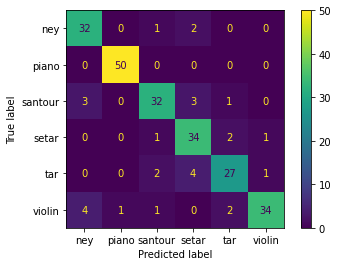


 SVC()
              precision    recall  f1-score   support

         ney       0.77      0.86      0.81        35
       piano       0.96      1.00      0.98        50
     santour       0.83      0.77      0.80        39
       setar       0.85      0.87      0.86        38
         tar       0.85      0.82      0.84        34
      violin       0.90      0.83      0.86        42

    accuracy                           0.87       238
   macro avg       0.86      0.86      0.86       238
weighted avg       0.87      0.87      0.87       238



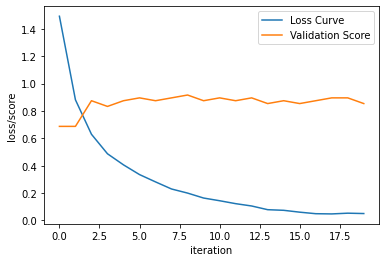

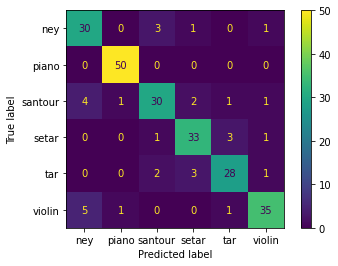


 SVC(kernel='linear')
              precision    recall  f1-score   support

         ney       0.76      0.89      0.82        35
       piano       0.94      0.98      0.96        50
     santour       0.81      0.74      0.77        39
       setar       0.79      0.87      0.82        38
         tar       0.84      0.76      0.80        34
      violin       0.89      0.76      0.82        42

    accuracy                           0.84       238
   macro avg       0.84      0.83      0.83       238
weighted avg       0.84      0.84      0.84       238



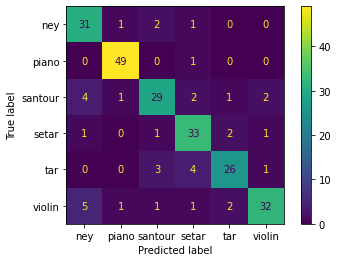


 GaussianNB()
              precision    recall  f1-score   support

         ney       0.67      0.69      0.68        35
       piano       0.92      0.98      0.95        50
     santour       0.72      0.54      0.62        39
       setar       0.78      0.76      0.77        38
         tar       0.66      0.74      0.69        34
      violin       0.56      0.60      0.57        42

    accuracy                           0.73       238
   macro avg       0.72      0.72      0.71       238
weighted avg       0.73      0.73      0.72       238



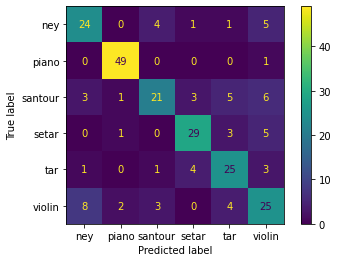

In [76]:
classifiers = [
    MLPClassifier(max_iter=100, early_stopping=True, learning_rate_init=0.001, 
                  validation_fraction=0.05,
                  verbose=False, hidden_layer_sizes=(256, 512, 512, 256)),
    SVC(kernel="rbf"),
    SVC(kernel="linear"),
    # SVC(kernel="poly"),
    GaussianNB(),
    # KNeighborsClassifier(10)
]

def eval(y_true, y_pred, clf=""):
    cr = classification_report(y_true, y_pred, target_names=mp3["target_names"])
    print(cr)
    data = parse_classification_report(str(cr))
    # print(report_to_latex_table(data))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mp3["target_names"])
    disp.plot()
    plt.savefig(f"cm_{clf}.pdf")
    plt.show()
    # plot_scatter(clf)

X_train, X_test, y_train, y_test = train_test_split(mp3["data"], mp3["target"], test_size=0.20, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
for clf in tqdm(classifiers):
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    print("\n", clf)
    eval(y_test, y_pred, clf)
    if "MLP" in str(clf):
        plt.plot(clf.loss_curve_, label="Loss Curve")
        plt.plot(clf.validation_scores_, label="Validation Score")
        plt.legend()
        plt.ylabel("loss/score")
        plt.xlabel("iteration")
        plt.savefig(f"MLP_loss.pdf")


In [ ]:
mp3["target_names"]

['ney', 'piano', 'santour', 'setar', 'tar', 'violin']